In [1]:
import numpy as np
import tensorflow as tf
import os
import glob
import matplotlib.pyplot as plt


In [2]:
# Function to parse TFRecord files
def _parse_function(proto):
    # Define your features
    keys_to_features = {
        'image': tf.io.FixedLenFeature([], tf.string),
    }

    # Load one example
    parsed_features = tf.io.parse_single_example(proto, keys_to_features)

    # Turn your saved image string into an array
    image = tf.io.decode_jpeg(parsed_features['image'])
    image = tf.image.resize(image, (32, 32))
    image = (image - 127.5) / 127.5
    return image

# Function to load images from TFRecord files
def load_images_from_tfrecords(directory_pattern):
    images = []
    for directory in glob.glob(directory_pattern):
        if os.path.isdir(directory):
            tfrecord_files = glob.glob(os.path.join(directory, '*.tfrec'))
            raw_image_dataset = tf.data.TFRecordDataset(tfrecord_files)
            parsed_image_dataset = raw_image_dataset.map(_parse_function)
            for image in parsed_image_dataset:
                images.append(image.numpy())
    return np.array(images)

# Define the directory pattern (adjust the path as necessary)
data_dir_pattern = './gan-getting-started/*'

# Load training images from multiple directories
x_train = load_images_from_tfrecords(data_dir_pattern)

# Reshape the data
x_train = x_train.reshape(x_train.shape[0], 32, 32, 3)


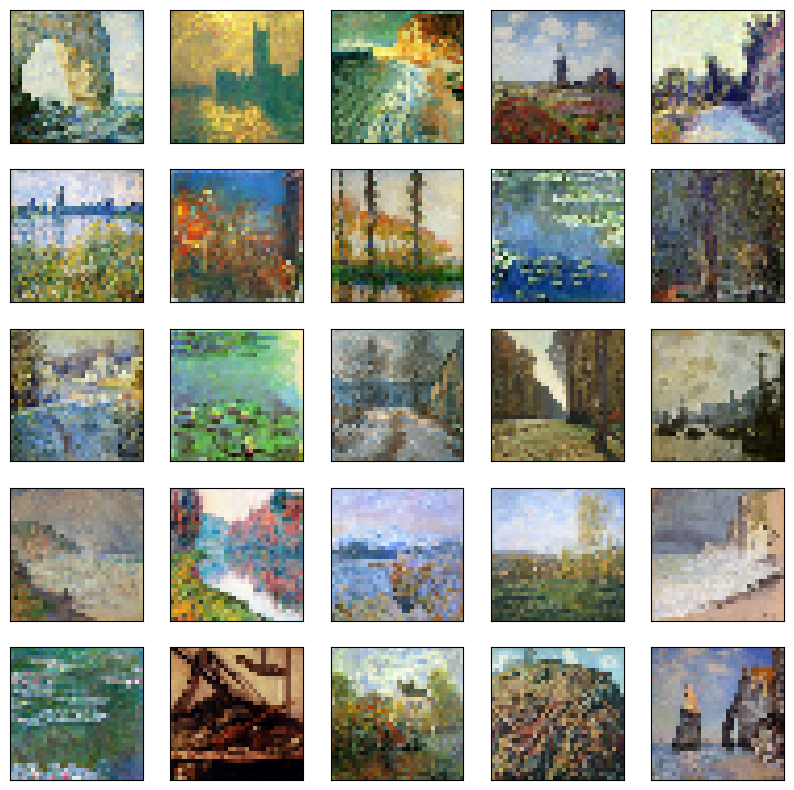

In [3]:
# Display a few images to verify
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow((x_train[i] + 1) / 2)  # Rescale to [0, 1] for display
plt.show()


In [4]:
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Sequential

def build_generator():
    model = Sequential()
    model.add(Dense(256 * 4 * 4, activation="relu", input_dim=100))
    model.add(Reshape((4, 4, 256)))
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", activation='tanh'))
    return model

generator = build_generator()
generator.summary()


C:\Users\Gyadav\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Gyadav\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 4096)                │         413,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 128)           │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 64)          │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 3)           │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,072,323 (4.09 MB)

 Trainable params: 1,072,323 (4.09 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.models import Sequential

def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=4, strides=2, padding="same", input_shape=(32, 32, 3)))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(128, kernel_size=4, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
discriminator.summary()


C:\Users\Gyadav\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 16, 16, 64)          │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 8, 8, 128)           │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 142,529 (556.75 KB)

 Trainable params: 142,529 (556.75 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Make the discriminator non-trainable when compiling the GAN model
discriminator.trainable = False

gan_input = tf.keras.Input(shape=(100,))
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=Adam())
gan.summary()


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 32, 32, 3)           │       1,072,323 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 1)                   │         142,529 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,214,852 (4.63 MB)

 Trainable params: 1,072,323 (4.09 MB)

 Non-trainable params: 142,529 (556.75 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0 [D loss: 0.9367613792419434, acc.: 14.871737360954285] [G loss: 0.4060783088207245]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


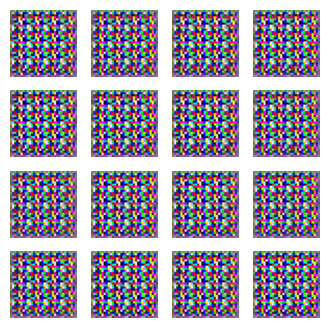

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━

In [11]:
def train_gan(gan, generator, discriminator, iterations, batch_size, sample_interval):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for iteration in range(iterations):
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        real_images = x_train[idx]
        
        noise = np.random.normal(0, 1, (batch_size, 100))
        generated_images = generator.predict(noise)
        
        d_loss_real = discriminator.train_on_batch(real_images, real)
        d_loss_fake = discriminator.train_on_batch(generated_images, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(noise, real)
        
        if iteration % sample_interval == 0:
            print(f"{iteration} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}] [G loss: {g_loss}]")
            sample_images(generator)

def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
    noise = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, 100))
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5
    
    fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize=(4, 4), sharey=True, sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(generated_images[cnt])
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

# iterations = 10000
# batch_size = 32
# sample_interval = 1000
iterations = 100
batch_size = 3
sample_interval = 100


train_gan(gan, generator, discriminator, iterations, batch_size, sample_interval)
